In [1]:
import pandas as pd
import numpy as np 
import surprise
from surprise import SVD
import matplotlib.pyplot as plt

import random

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV, split

from surprise import KNNBasic


In [2]:
df_books = pd.read_csv("books.csv")
df_ratings = pd.read_csv('ratings.csv')

## EDA

In [3]:
df_books.shape

(10000, 23)

In [4]:
df_books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [5]:
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
# checking data type & missing values

print("\n---------- books -----------")
print(df_books.info())
print("\n---------- ratings -----------")
print(df_ratings.info())


---------- books -----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count    

Number of uniq user count 53424
Average rating count per user 111.86880428271938


<AxesSubplot:>

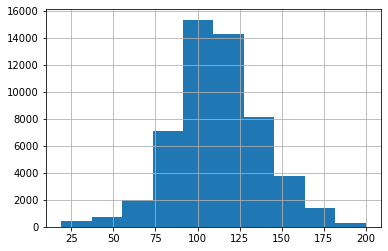

In [7]:
# check the user counts and rating count per user

print("Number of uniq user count", len(df_ratings.user_id.unique()))
print("Average rating count per user", len(df_ratings) / len(df_ratings.user_id.unique()))

df_ratings_grouped = df_ratings.groupby("user_id").count()['rating']
(df_ratings_grouped).hist()

<AxesSubplot:>

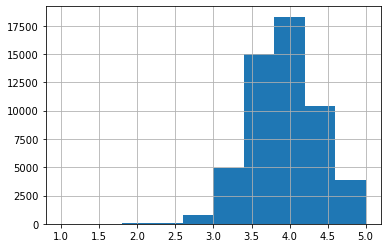

In [8]:
# check rating scores

df_ratings_grouped = df_ratings.groupby("user_id").mean()['rating']
(df_ratings_grouped).hist()

In [9]:
# check most rated books

print("Top 5 books by rating_counts")
df_books[['title','ratings_count']].sort_values(by=['ratings_count'], ascending=False).head(5)

Top 5 books by rating_counts


,title,ratings_count
0,"The Hunger Games (The Hunger Games, #1)",4780653
1,Harry Potter and the Sorcerer's Stone (Harry P...,4602479
2,"Twilight (Twilight, #1)",3866839
3,To Kill a Mockingbird,3198671
4,The Great Gatsby,2683664


In [10]:
# check highly rated books

print("Top 5 books by average_rating")
df_books[['title','average_rating']].sort_values(by=['average_rating'], ascending=False).head(5)

Top 5 books by average_rating


,title,average_rating
3627,The Complete Calvin and Hobbes,4.82
3274,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77
861,"Words of Radiance (The Stormlight Archive, #2)",4.77
8853,Mark of the Lion Trilogy,4.76
7946,ESV Study Bible,4.76


## Recommendation Algorithms from Lecture 2

KNN User Based

In [11]:
# Reduce the dataset to 0.5%
df_ratings_condensed = df_ratings.sample(frac = 0.005)
data = surprise.Dataset.load_from_df(df_ratings_condensed[['user_id', 'book_id', 'rating']], surprise.Reader(rating_scale=(1, 5)))


In [12]:
# performing grid search for KNN User Based

param_grid = {'k': [1, 2, 5, 10],
              'sim_options': {'name': ['cosine']},
                              'user_based': [True]}
grid = surprise.model_selection.search.GridSearchCV(KNNBasic, param_grid=param_grid, return_train_measures = True, cv=3)
grid.fit(data)
print(grid.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
{'k': 1, 'sim_options': {'name': 'cosine', 'user_based': True}, 'user_based': True}


In [13]:
results = pd.DataFrame(grid.cv_results)

In [14]:
groupedBy = results.groupby("param_k").agg(
    {
        "param_k": "mean",
        "mean_test_rmse": "mean",
        "std_test_rmse": "mean",
        "mean_train_rmse": "mean",
        "std_train_rmse": "max",
    }
)
groupedBy.head()

,param_k,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
param_k,,,,,
1,1,0.992433,0.006646,1.145353,0.006529
2,2,0.992480,0.006648,0.950833,0.005531
5,5,0.992480,0.006648,0.841617,0.000876
10,10,0.992480,0.006648,0.813917,0.001103


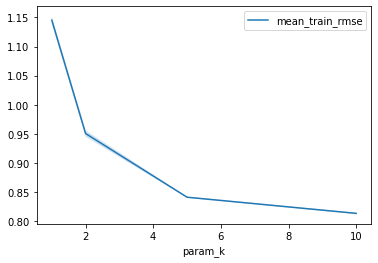

In [15]:
#plotting the grid search results on a train set
groupedBy.plot('param_k', 'mean_train_rmse')

plt.fill_between(groupedBy['param_k'].astype(np.int),
                 groupedBy['mean_train_rmse'] + groupedBy['std_train_rmse'],
                 groupedBy['mean_train_rmse'] - groupedBy['std_train_rmse'], alpha=0.2)

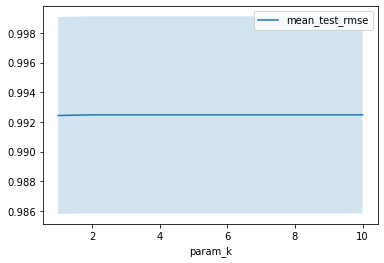

In [16]:
#plotting the grid search results on a validation set

groupedBy.plot('param_k', 'mean_test_rmse', ax=plt.gca())

plt.fill_between(groupedBy.param_k.astype(np.int),
                 groupedBy['mean_test_rmse'] + groupedBy['std_test_rmse'],
                 groupedBy['mean_test_rmse'] - groupedBy['std_test_rmse'], alpha=0.2)


In [17]:
grid.best_score['rmse']

0.9924332672583919

KNN Item Based

In [49]:
# reset (taking 10% of the dataset)
df_ratings_condensed = df_ratings.sample(frac = 0.1)
data = surprise.Dataset.load_from_df(df_ratings_condensed[['user_id', 'book_id', 'rating']], surprise.Reader(rating_scale=(1, 5)))


In [50]:
# performing grid search for KNN Item based

param_grid = {'k':  [1, 2, 5, 10],
              'sim_options': {'name': [ 'cosine'],
                              'user_based': [False]}}
grid = surprise.model_selection.search.GridSearchCV(KNNBasic, param_grid=param_grid, return_train_measures = True, cv=3)
grid.fit(data)
print(grid.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
{'k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}}


In [51]:
results = pd.DataFrame(grid.cv_results)


In [52]:
groupedBy = results.groupby("param_k").agg(
    {
        "param_k": "mean",
        "mean_test_rmse": "mean",
        "std_test_rmse": "mean",
        "mean_train_rmse": "mean",
        "std_train_rmse": "max",
    }
)
groupedBy.head()

,param_k,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
param_k,,,,,
1,1,1.202249,0.001417,1.085169,0.001697
2,2,1.093518,0.001147,0.901493,0.001322
5,5,1.046700,0.001375,0.804825,0.000816
10,10,1.043111,0.001457,0.813537,0.001020


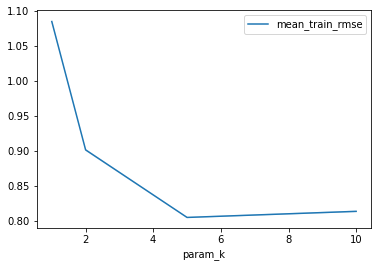

In [53]:
#plotting the grid search results on a train set
groupedBy.plot('param_k', 'mean_train_rmse')

plt.fill_between(groupedBy['param_k'].astype(np.int),
                 groupedBy['mean_train_rmse'] + groupedBy['std_train_rmse'],
                 groupedBy['mean_train_rmse'] - groupedBy['std_train_rmse'], alpha=0.2)


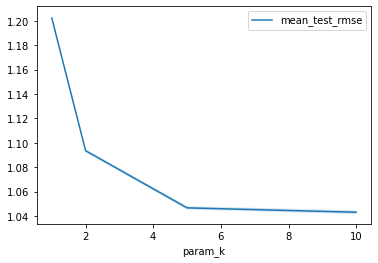

In [54]:
#plotting the grid search results on a validation set

groupedBy.plot('param_k', 'mean_test_rmse', ax=plt.gca())

plt.fill_between(groupedBy.param_k.astype(np.int),
                 groupedBy['mean_test_rmse'] + groupedBy['std_test_rmse'],
                 groupedBy['mean_test_rmse'] - groupedBy['std_test_rmse'], alpha=0.2)

In [55]:
grid.best_score['rmse']

1.0431109089790898

Matrix Factorization

In [25]:
#reduce training size because GridSearchCV is computationally heavy. 
#We randomly select 10% of the data to be used for cross validation and reserve 90% of the data for testing purposes,
#to avoid leakage to the test set

df_ratings_10 = df_ratings.sample(frac = 0.10, random_state = 42)
df_ratings_90 = df_ratings.drop(df_ratings_10.index)
data = surprise.Dataset.load_from_df(df_ratings_10[['user_id', 'book_id', 'rating']], surprise.Reader(rating_scale=(1, 5)))

In [26]:
#Matrix Factorization using SGD. We tune the number of latent factors to extract from the data here
#We use a random state so that are results are reproducible
CV = surprise.model_selection.split.KFold(n_splits=5, random_state=42, shuffle=True)
param_grid = {"n_factors": [1, 2, 5, 10, 20, 100], "random_state": [42]}
grid = surprise.model_selection.search.GridSearchCV(SVD, 
                                                    param_grid = param_grid,return_train_measures = True,
                                                    cv=CV, n_jobs = -2)
grid.fit(data)

print('rmse:')
print(grid.best_params['rmse'])

print('mae:')
print(grid.best_params['mae'])

rmse:
{'n_factors': 1, 'random_state': 42}
mae:
{'n_factors': 1, 'random_state': 42}


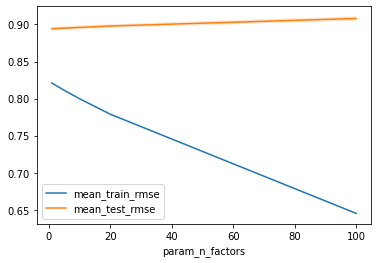

In [27]:
#plotting the grid search results, code template courtesy of notebooks shared by the teacher for the ML class.
#Relevant parameters adjusted to make it work with the surprise package
#RMSE
results = pd.DataFrame(grid.cv_results)
results.plot('param_n_factors', 'mean_train_rmse')
results.plot('param_n_factors', 'mean_test_rmse', ax=plt.gca())

plt.fill_between(results.param_n_factors.astype(float),
                 results['mean_train_rmse'] + results['std_train_rmse'],
                 results['mean_train_rmse'] - results['std_train_rmse'], alpha=0.2)
plt.fill_between(results.param_n_factors.astype(float),
                 results['mean_test_rmse'] + results['std_test_rmse'],
                 results['mean_test_rmse'] - results['std_test_rmse'], alpha=0.2)
plt.legend()



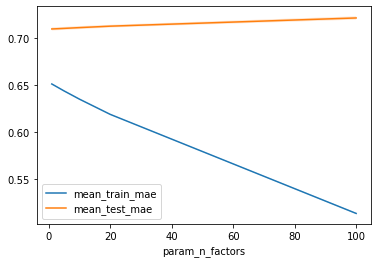

In [28]:
#MAE
results = pd.DataFrame(grid.cv_results)
results.plot('param_n_factors', 'mean_train_mae')
results.plot('param_n_factors', 'mean_test_mae', ax=plt.gca())

plt.fill_between(results.param_n_factors.astype(float),
                 results['mean_train_mae'] + results['std_train_mae'],
                 results['mean_train_mae'] - results['std_train_mae'], alpha=0.2)
plt.fill_between(results.param_n_factors.astype(float),
                 results['mean_test_mae'] + results['std_test_mae'],
                 results['mean_test_mae'] - results['std_test_mae'], alpha=0.2)
plt.legend()

a very small number of factors already results in good test results. Increasing the number of factors results in overfitting (low RMSE on the train set but no improvement on the validation set).

In [29]:
#tuning another SVD parameter, the regularization term
param_grid = {"reg_all": [0,0.02, 0.04, 0.10, 0.20, 0.30, 0.50, 1,2,3,4] }
grid = surprise.model_selection.search.GridSearchCV(SVD, param_grid = param_grid,return_train_measures = True,
                                                    cv=CV, n_jobs = -2)
grid.fit(data)
print('rmse:')
print(grid.best_params['rmse'])

print('mae:')
print(grid.best_params['mae'])

rmse:
{'reg_all': 0.2}
mae:
{'reg_all': 0.2}


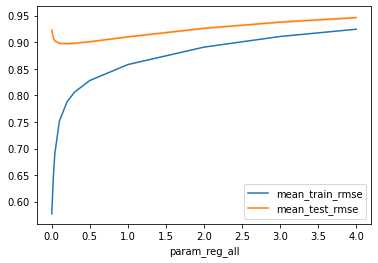

In [30]:
#plotting the GridSearch results for RMSE
results = pd.DataFrame(grid.cv_results)
results.plot('param_reg_all', 'mean_train_rmse')
results.plot('param_reg_all', 'mean_test_rmse', ax=plt.gca())

plt.fill_between(results.param_reg_all.astype(float),
                 results['mean_train_rmse'] + results['std_train_rmse'],
                 results['mean_train_rmse'] - results['std_train_rmse'], alpha=0.2)
plt.fill_between(results.param_reg_all.astype(float),
                 results['mean_test_rmse'] + results['std_test_rmse'],
                 results['mean_test_rmse'] - results['std_test_rmse'], alpha=0.2)
plt.legend()


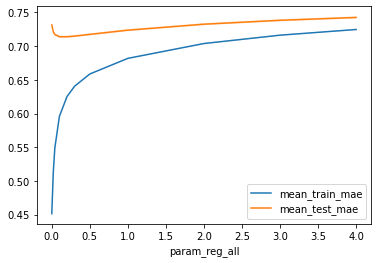

In [31]:
#MAE
results = pd.DataFrame(grid.cv_results)
results.plot('param_reg_all', 'mean_train_mae')
results.plot('param_reg_all', 'mean_test_mae', ax=plt.gca())

plt.fill_between(results.param_reg_all.astype(float),
                 results['mean_train_mae'] + results['std_train_mae'],
                 results['mean_train_mae'] - results['std_train_mae'], alpha=0.2)
plt.fill_between(results.param_reg_all.astype(float),
                 results['mean_test_mae'] + results['std_test_mae'],
                 results['mean_test_mae'] - results['std_test_mae'], alpha=0.2)
plt.legend()

In [32]:
#re-running the gridsearch with both parameters included (number of parameters and cross validation minimized due to
#computational restrictions)
param_grid = {"reg_all": [ 0.02, 0.2, 0.3], "n_factors": [ 1, 2, 5, 100] }
grid = surprise.model_selection.search.GridSearchCV(SVD, param_grid = param_grid,return_train_measures = True,
                                                    cv=CV, n_jobs = -2)
grid.fit(data)

# best RMSE score of the model with the optimal parameters
print(grid.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid.best_params['rmse'])


0.8941602811324973
{'reg_all': 0.02, 'n_factors': 1}


In [33]:
#using the rest of the data (90%)
data = surprise.Dataset.load_from_df(df_ratings_90[['user_id', 'book_id', 'rating']], surprise.Reader(rating_scale=(1, 5)))
train, test = surprise.model_selection.train_test_split(data, train_size=0.75, test_size=.25)

In [34]:
import time

start_time = time.time()

# Train the algorithm on the full dataset with the optimal parameters
algo = SVD(n_factors=1, reg_all=0.02, random_state = 42)
algo.fit(train)
predictions = algo.test(test)

# Then compute RMSE/MAE
surprise.accuracy.rmse(predictions)
surprise.accuracy.mae(predictions)

#calculate runtime
end_time = time.time()
runtime = (end_time - start_time)/60
print('this program ran for', runtime, 'minutes')

RMSE: 0.8530
MAE:  0.6653
this program ran for 2.587093957265218 minutes


In [35]:
start_time = time.time()

# Train the algorithm on the full dataset with the optimal parameters
algo = SVD(n_factors=100, reg_all=0.02, random_state = 42)
algo.fit(train)
predictions = algo.test(test)

# Then compute RMSE
surprise.accuracy.rmse(predictions)
surprise.accuracy.mae(predictions)

end_time = time.time()
runtime = (end_time - start_time)/60
print('this program ran for', runtime, 'minutes')

RMSE: 0.8404
MAE:  0.6505
this program ran for 7.348831343650818 minutes


After all, the default values of SVD (100 factors, reg_all = 0.02) have the best performance when trained on the full dataset. Increasing the number of factors increases computing time. Overall, the computing time is still very reasonable comparing to KNN.

In [36]:
# Now train on full dataset
data = surprise.Dataset.load_from_df(df_ratings[['user_id', 'book_id', 'rating']], surprise.Reader(rating_scale=(1, 5)))
train_full = data.build_full_trainset()
algo.fit(train_full)

# Predictions test

In [37]:
#preductions for one of the team members
library = ["book_id", "title", "authors", 'average_rating']

personal_rating =  [
    { "book_id": 4, "rating": 5},
    { "book_id": 5, "rating": 5},
    { "book_id": 8, "rating": 5},
    { "book_id": 26, "rating": 2},
    { "book_id": 35, "rating": 2},
    { "book_id": 43, "rating": 4},
    { "book_id": 92, "rating": 4},
    { "book_id": 103, "rating": 3},
    { "book_id": 116 ,"rating": 5},
    { "book_id": 121,"rating": 3},
    { "book_id": 128 ,"rating": 2},
    { "book_id": 146 ,"rating":4 },
    { "book_id": 172 ,"rating":5 },
    { "book_id": 173 ,"rating":5 },
    { "book_id": 177 ,"rating":4 },
    { "book_id": 179 ,"rating":2 },
    { "book_id": 196 ,"rating":3 },
    { "book_id": 408 ,"rating":4 },
    
]

df_personal_rating = pd.DataFrame(personal_rating)
df_personal_rating["user_id"] = 99999

In [38]:
# add to the table

df_ratings = df_ratings.append(df_personal_rating, ignore_index=True)

df_ratings.tail(25)

,user_id,book_id,rating
5976472,23863,8020,4
5976473,49925,330,5
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5
5976478,49925,1023,4
5976479,99999,4,5
5976480,99999,5,5
5976481,99999,8,5


In [39]:
df_personal_rating = df_personal_rating[['user_id', 'book_id', 'rating']]

In [40]:
# predictions for a new user
uid = 99999
books = df_ratings["book_id"].unique()

predictions = [
    algo.predict(uid, book_id)
    for book_id in books
]

df_pred = pd.DataFrame(predictions)

df_pred = df_pred.sort_values("est", ascending=False)

In [41]:
df_pred

,uid,iid,r_ui,est,details
479,99999,8946,None,4.956178,{'was_impossible': False}
1534,99999,3628,None,4.856607,{'was_impossible': False}
976,99999,6920,None,4.819543,{'was_impossible': False}
1830,99999,9566,None,4.808565,{'was_impossible': False}
975,99999,6590,None,4.780729,{'was_impossible': False}
...,...,...,...,...,...
8006,99999,4991,None,2.569387,{'was_impossible': False}
7861,99999,1822,None,2.568932,{'was_impossible': False}
7131,99999,7636,None,2.425967,{'was_impossible': False}
9499,99999,4045,None,2.399326,{'was_impossible': False}


In [42]:
df_pred = df_pred.merge(df_books[library], left_on='iid', right_on="book_id")
df_pred.columns

Index(['uid', 'iid', 'r_ui', 'est', 'details', 'book_id', 'title', 'authors',
       'average_rating'],
      dtype='object')

In [43]:
# displaying top ten recommendations

df_pred[library].head(10)

,book_id,title,authors,average_rating
0,8946,The Divan,Hafez,4.63
1,3628,The Complete Calvin and Hobbes,Bill Watterson,4.82
2,6920,The Indispensable Calvin and Hobbes,Bill Watterson,4.73
3,9566,Attack of the Deranged Mutant Killer Monster S...,Bill Watterson,4.72
4,6590,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson,4.73
5,7947,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",4.76
6,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,4.77
7,5207,The Days Are Just Packed: A Calvin and Hobbes ...,Bill Watterson,4.68
8,8978,The Revenge of the Baby-Sat,Bill Watterson,4.71
9,7254,Homicidal Psycho Jungle Cat: A Calvin and Hobb...,Bill Watterson,4.71


In [44]:
# predictions for a new user
uid = 13365
books = df_ratings["book_id"].unique()

predictions = [
    algo.predict(uid, book_id)
    for book_id in books
]

df_pred = pd.DataFrame(predictions)

df_pred = df_pred.sort_values("est", ascending=False)

In [45]:
df_pred = df_pred.merge(df_books[library], left_on='iid', right_on="book_id")
df_pred[library].head(10)

,book_id,title,authors,average_rating
0,951,Survivor,Chuck Palahniuk,3.93
1,484,Choke,Chuck Palahniuk,3.69
2,1657,Infinite Jest,David Foster Wallace,4.31
3,1503,Jitterbug Perfume,Tom Robbins,4.24
4,1124,Lullaby,Chuck Palahniuk,3.73
5,238,Running with Scissors,Augusten Burroughs,3.70
6,663,A People's History of the United States,Howard Zinn,4.07
7,1236,Haunted,Chuck Palahniuk,3.59
8,2058,My Grandmother Asked Me to Tell You She's Sorry,"Fredrik Backman, Henning Koch",4.02
9,2035,Squirrel Seeks Chipmunk: A Modest Bestiary,"David Sedaris, Ian Falconer",3.34


In [46]:
x = df_ratings[df_ratings['user_id']==13365].sort_values('rating', ascending=False)

In [47]:
x

,user_id,book_id,rating
828812,13365,8874,5
828813,13365,9900,5
828811,13365,4282,5
828741,13365,100,5
828807,13365,1645,5
...,...,...,...
828753,13365,222,1
828748,13365,11,1
828747,13365,26,1
828745,13365,121,1


In [48]:
df_pred = x.merge(df_books[library], left_on='book_id', right_on="book_id")
df_pred

,user_id,book_id,rating,title,authors,average_rating
0,13365,8874,5,Tell-All,Chuck Palahniuk,2.84
1,13365,9900,5,Guts,Chuck Palahniuk,3.93
2,13365,4282,5,Pygmy,Chuck Palahniuk,2.96
3,13365,100,5,The Poisonwood Bible,Barbara Kingsolver,4.02
4,13365,1645,5,Rant,Chuck Palahniuk,3.82
...,...,...,...,...,...,...
99,13365,222,1,"The Bourne Identity (Jason Bourne, #1)",Robert Ludlum,3.98
100,13365,11,1,The Kite Runner,Khaled Hosseini,4.26
101,13365,26,1,"The Da Vinci Code (Robert Langdon, #2)",Dan Brown,3.79
102,13365,121,1,Lolita,"Vladimir Nabokov, Craig Raine",3.88
